# **Predicting S&P 500 Prices from NYT and WSJ Headlines**

**Authors**: James Strong, Elizabeth Zhong, Matthew Allana, William Ma, Rohil Daliwal

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Table Of Contents**
1. Problem Statement
2. Our Approach
3. Headline Data Cleaning and Processing: Sentiment Analysis
4. Start the notebook at this block!
5. Data Exploration and Visualization
    - NYT and WSJ Headlines
    - S&P500 Data
    - Combine Headlines and S&P500 Data
6. Baseline Model: Majority Class
7. Final Models: 
    - Random Forest
    - AdaBoosting
8. Model Interpretation and Results

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Problem Statement**

#### **Context**

Financial markets are highly sensitive to news and public sentiment, making accurate market predictions a challenging yet essential task for investors, analysts, and policymakers. Traditional methods of predicting stock market trends often rely on historical price data, technical indicators, and economic metrics, but they may overlook the impact of real-time news sentiment on market dynamics. This project aims to address this gap by leveraging the sentiment of headlines from the New York Times (NYT) and Wall Street Journal (WSJ) as a proxy for public and market sentiment. By analyzing how the tone and context of headlines correlate with movements in the S&P 500 index, we seek to uncover patterns that can complement existing predictive models. This approach reflects the growing importance of sentiment analysis in financial forecasting, recognizing the critical role that media and public perception play in shaping market behavior.

#### **Motivation**

The motivation for building a model to predict S&P 500 closing prices using the sentiments of New York Times (NYT) and Wall Street Journal (WSJ) headlines lies in the significant influence that public sentiment and news have on financial markets. Headlines often capture prevailing market sentiment, economic developments, and geopolitical events, which can drive investor behavior and, consequently, market movements. By analyzing the sentiment expressed in NYT headlines, we aim to extract valuable insights into market sentiment that could enhance traditional financial models. Integrating sentiment analysis with market prediction can improve the timeliness and accuracy of forecasts, providing a more comprehensive tool for investors and analysts to make informed decisions in a rapidly changing economic environment.

#### **Problem Statement** 

Using various sentiment analysis methods (VADER, TextBlob, BERT), we aim to compute sentiment scores for NYT headlines and WSJ headline between 1998 and 2020. Each headline includes a date and section field as well. NYT headlines were collected from 1990 to 2020 (avoiding harder to predict post-COVID fluctuations in the market). WSJ headlines were collected from 1998 to 2021. For this reason, we will use the years in overlap to perform sentiment analysis (1998 - 2020). Subsequent S&P 500 data closing prices have been collected at each time period during this timeframe, and we scaled these values to account for inflation.

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Our Approach**

We created a dataframe with an entry for each time point. For that time point, we average the sentiment scores for that day, and also add the number of headlines from each section into the row. Finally, our response is the S&P 500 closing price.

For the sentiment analysis, we used three different methods - VADER and TextBlob and BERT - to give a score to each NYT and WSJ article headline. Due to the short nature of each headline (on average 6 words or less), the majority of scores are 0, thus we exclude sentiment scores of 0 in order to assess either a positive or negative value for the time period - we will experiment with this threshold. It should be noted that there are many more headlines for the WSJ compared to the NYT, so we could only perform BERT on the WSJ enteries due to the computational time to incorporate this model. After testing multiple time points in milestones 4, we concluded that the average sentiment analysis for each month worked best to predict the S&P 500. This means we have a df where each row is a day date (averaged sentiment scores for that day and S&P closing price for that day), week (averaged sentiment scores for that day and averaged S&P closing price for that week) and so on.

#### **Datasets** 

For our **headline sentiment analysis**, we sourced two datasets -- New York Times headlines and Wall Street Journal headlines. These datasets are both cited from Kaggle.

1. Kaggle Wall Street Journal: https://www.kaggle.com/datasets/amogh7joshi/wsj-headline-classification/data

    The dataset consists of over 19,000 headlines scraped from the Wall Street Journal archives, spanning the period from May 3, 1998, to June 30, 2021. The headlines are organized into 67 categories based on the Wall Street Journal's classification system, making the dataset a valuable resource for tasks such as news category classification and unsupervised clustering. Headlines were randomly sampled (3-4 per day) and categorized, with categories containing fewer than 100 entries removed.

2. Kaggle New York Times: https://www.kaggle.com/datasets/johnbandy/new-york-times-headlines

    This dataset contains headlines from articles published by The New York Times between 1990 and 2020, along with accompanying metadata such as author, URL, word count, section, and more. It was created in July 2021 using The New York Times Article Search API. While it provides a comprehensive archive for text analysis and research, some records may have incomplete data due to API limitations.

For our **S&P closing prices**, we are using Python’s built-in Yahoo Finance function (yfinance) to pull historical stock market data and storing it in a dataframe.

#### **Dependencies**

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

import yfinance as yf

import torch
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from wordcloud import WordCloud

import warnings

`sklearn`: For model training, evaluation, and optimization.

`yfinance`: Fetches historical financial market data, which we used to extract stock prices and related financial information for analysis.

`textblob`: For TextBlob sentiment analysis and extracting sentiment scores from headline text.

`vaderSentiment`: For lexicon-based sentiment analysis, particularly designed for short text like news headlines and extracting sentiment scores from headline text.

`transformers`: Provides tools for transformer models like BERT. We specifically used `AutoTokenizer` and `AutoModelForSequenceClassification` for implementing pre-trained BERT models to perform sentiment analysis.

`imbalanced-learn`: We used `SMOTE` (Synthetic Minority Oversampling Technique) for handling imbalanced datasets, which ensures balanced training datasets for better model performance.

`tqdm`: Displays progress bars for loops and iterations that allow us to see progress updates during particularly long sentiment analysis trials.

#### **Pipeline**

![pipeline.jpg](pipeline.jpg)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Headline Data Cleaning and Processing: Sentiment Analysis**

#### **Cleaning Headline Datasets**

First, we load and process the NYT and WSJ headline datasets. Since we plan to implement sentiment analysis on just the headline text and investigate these sentiments over time, the columns of interest are the publishing dates and the headline text. Note that the NYT headline dataset is more rich (including authors, word count, and more), however, we will limit the scope to just the headline text.

In [13]:
# load NYT and WSJ headline datasets
archive_path = "archive"
dfs = []
for filename in os.listdir(archive_path):
    if filename.endswith(".csv") and filename.startswith("new_york_times_stories_"):
        file_path = os.path.join(archive_path, filename)
        
        df = pd.read_csv(file_path, dtype={"print_page": str})
        dfs.append(df)

data_nyt= pd.concat(dfs, ignore_index=True)
data_wsj = pd.read_csv("./archive/wsj_headlines.csv")

Let's take a peek at these dataframes!

In [14]:
# NYT Headlines
display(data_nyt.head())

,headline,source,word_count,url,print_section,print_page,author,type,pub_date,news_desk,section,year
0,Bridge,The New York Times,411.0,https://www.nytimes.com/1990/01/01/nyregion/br...,1,45.0,By Alan Truscott,article,1990-01-01T05:00:00+0000,Metropolitan Desk,New York,1990.0
1,He Has Tyson On His Mind,The New York Times,199.0,https://www.nytimes.com/1990/01/01/sports/spor...,1,38.0,By Phil Berger,article,1990-01-01T05:00:00+0000,Sports Desk,Sports,1990.0
2,"For Dinkins, Pomp, Ceremony, Triumph And a Dre...",The New York Times,1233.0,https://www.nytimes.com/1990/01/01/nyregion/fo...,1,27.0,By Don Terry,article,1990-01-01T05:00:00+0000,Metropolitan Desk,New York,1990.0
3,Army Doesn't Have to Compete With Marines; W...,The New York Times,524.0,https://www.nytimes.com/1990/01/01/opinion/l-a...,1,24.0,NaN,article,1990-01-01T05:00:00+0000,Editorial Desk,Opinion,1990.0
4,Students Must Get to School and Back Safely,The New York Times,363.0,https://www.nytimes.com/1990/01/01/opinion/l-s...,1,24.0,NaN,article,1990-01-01T05:00:00+0000,Editorial Desk,Opinion,1990.0


In [15]:
# WSJ Headlines
display(data_wsj.head())

,Unnamed: 0,Date,Headline,Category
0,0,01/26/2012,Mother Nature Raps Natural Gas,Markets
1,1,06/15/2007,Subprime Woes Pinch Bear's Mortgage Star,US Business News
2,2,01/24/2011,Facebook Alters Tool in German Privacy Deal,Technology
3,3,02/20/2014,EU Ministers Clear Sanctions on Ukraine,World News
4,4,01/09/2011,Authorities Seek Possible Associate of Suspect,Politics


For consistency, we will rename the columns of both CSVs and align the start date to be July 1998 - January 2020.

In [16]:
# NYT headline data
df_nyt = data_nyt[["headline", "pub_date", "source"]].copy()
df_nyt = df_nyt[(df_nyt['pub_date'] >= '1998-07-01') & (df_nyt['pub_date'] < '2020-01-01')]
df_nyt.rename(columns={'pub_date': 'date'}, inplace=True)
df_nyt['date'] = pd.to_datetime(df_nyt['date'], errors='coerce', utc=True)
df_nyt["source"] = "nyt"

In [17]:
# WSJ headline data
df_wsj = data_wsj[["Date", "Headline"]].copy()
df_wsj['Date'] = pd.to_datetime(df_wsj['Date'], errors='coerce', utc=True)
df_wsj = df_wsj[(df_wsj['Date'] >= '1998-07-01') & (df_wsj['Date'] < '2020-01-01')]
df_wsj.rename(columns={'Date': 'date', 'Headline': 'headline'}, inplace=True)
df_wsj["source"] = "wsj"

In [18]:
display(df_nyt.head())
display(df_wsj.head())

,headline,date,source
742544,Lithium Battery Ban? Check Again,2008-01-01 00:02:35+00:00,nyt
742545,New Year’s Day Bowl Matchups,2008-01-01 00:21:03+00:00,nyt
742546,"Eight Years, And Back To The Start",2008-01-01 00:33:08+00:00,nyt
742547,Tackling Clutter to Improve Your Health,2008-01-01 01:11:43+00:00,nyt
742548,World Juniors: U.S. and Sweden Run the Table i...,2008-01-01 01:26:38+00:00,nyt


,date,headline,source
0,2012-01-26 00:00:00+00:00,Mother Nature Raps Natural Gas,wsj
1,2007-06-15 00:00:00+00:00,Subprime Woes Pinch Bear's Mortgage Star,wsj
2,2011-01-24 00:00:00+00:00,Facebook Alters Tool in German Privacy Deal,wsj
3,2014-02-20 00:00:00+00:00,EU Ministers Clear Sanctions on Ukraine,wsj
4,2011-01-09 00:00:00+00:00,Authorities Seek Possible Associate of Suspect,wsj


Now, we check for missingess to ensure our datset is complete.

In [19]:
# Check for missingness
print("NYT Headline Missingness Summary")
display(df_nyt.isnull().sum())

print("WSJ Headline Missingness Summary")
display(df_wsj.isnull().sum())

NYT Headline Missingness Summary


headline    565
date          0
source        0
dtype: int64

WSJ Headline Missingness Summary


date        0
headline    0
source      0
dtype: int64

In [20]:
df_nyt = df_nyt.dropna(subset=["headline"])
display(df_nyt.isnull().sum())

headline    0
date        0
source      0
dtype: int64

**Headline Distribution Visualization**

To better visualize the headline distribution over time, let's plot the annual headline count for both the Wall Street Journal and New York Times headlines datasets.

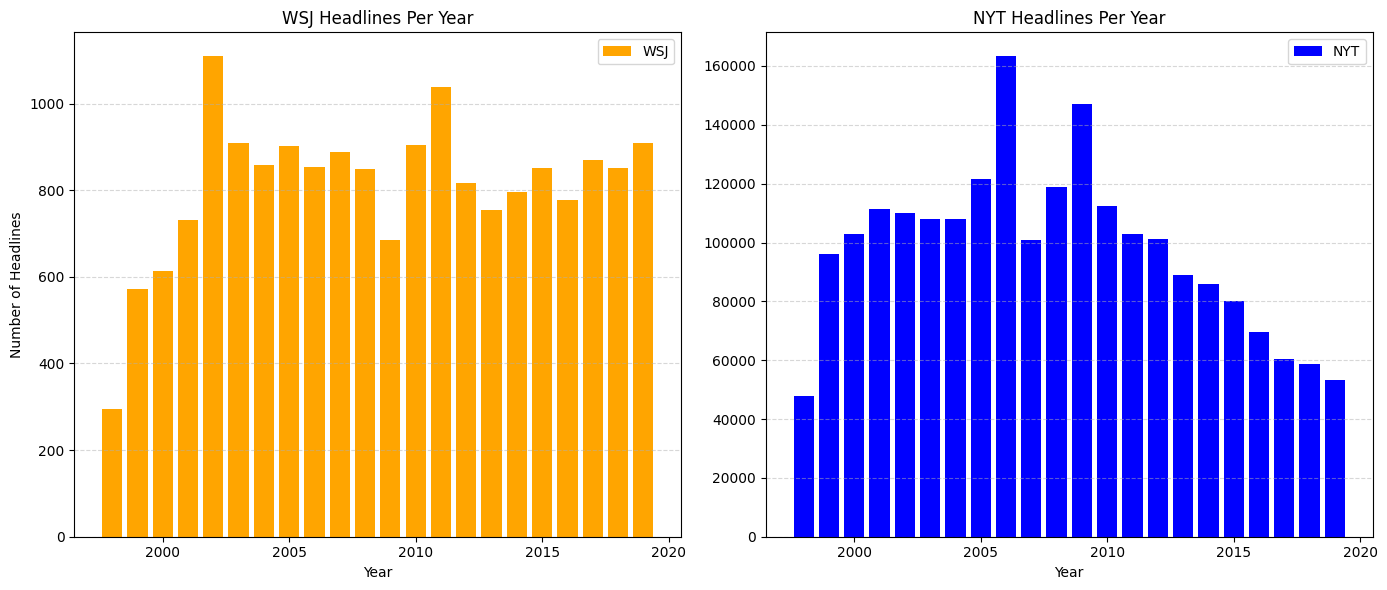

In [21]:
df_wsj['year'] = df_wsj['date'].dt.year
df_nyt['year'] = df_nyt['date'].dt.year

# Filter and count headlines for WSJ and NYT by year
wsj_headlines_per_year = df_wsj[df_wsj['source'].str.lower() == 'wsj'].groupby('year')['headline'].count()
nyt_headlines_per_year = df_nyt[df_nyt['source'].str.lower() == 'nyt'].groupby('year')['headline'].count()

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# WSJ Headlines Plot
axs[0].bar(wsj_headlines_per_year.index, wsj_headlines_per_year.values, color='orange', label='WSJ')
axs[0].set_title('WSJ Headlines Per Year')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Headlines')
axs[0].grid(axis='y', linestyle='--', alpha=0.5)
axs[0].legend()

# NYT Headlines Plot
axs[1].bar(nyt_headlines_per_year.index, nyt_headlines_per_year.values, color='blue', label='NYT')
axs[1].set_title('NYT Headlines Per Year')
axs[1].set_xlabel('Year')
axs[1].grid(axis='y', linestyle='--', alpha=0.5)
axs[1].legend()
plt.tight_layout()
plt.show()

**Notes**

The WSJ graph shows a steady increase in the number of headlines from 1998, peaking around 2002, followed by relatively consistent levels until 2020. Conversely, the NYT graph highlights a much larger volume of headlines annually, with a significant spike in the mid-2000s, suggesting an increase in published articles during that time. After the peak, there is a gradual decline in the number of headlines leading up to 2020. Overall, the volume of NYT headlines far exceeds the number of WSJ headlines (nearly 160x).

___________________

## **Processing: Sentiment Analysis of Headlines**

Now that we have cleaned the datasets, we will implement sentiment analysis (SA) on the headline texts using three techniques:
1. **TextBlob**:
    
    TextBlob is a Python library implements SA by assigning polarity (specifically positive, neutral, or negative) and subjectivity (objective or subjective) scores to text. It uses a rule-based approach and a pre-defined lexicon to calculate these scores.

2. **VADER**: 

    VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool specifically designed for social media and short texts. It captures sentiment intensity and accounts for contextual nuances like negation and emphasis (e.g., "not good" or "very good") by returning a compound sentiment score ranging from -1 (most negative) to +1 (most positive).

3. **BERT**: 

    BERT (Bidirectional Encoder Representations from Transformers) is a deep learning-based technique that uses contextual word embeddings to analyze sentiment. By leveraging pre-trained transformer models, it can understand the contextual meaning of words in a sentence, offering highly accurate sentiment classification. It provides predictions such as "positive," "neutral," or "negative" with associated confidence scores.

Note: Given the extremely large size of the NYT headline data, we have decided not conduct BERT sentiment analysis on these headlines.

#### `TextBlob`

Using `TextBlob`, we store the polarity score (a float ranging between -1 and 1) as the TextBlob sentiment score. 

(1 min 44 sec)

In [22]:
def get_textblob_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df_nyt['textblob_nyt'] = df_nyt['headline'].apply(get_textblob_sentiment)
df_wsj['textblob_wsj'] = df_wsj['headline'].apply(get_textblob_sentiment)

#### `VADER`

Using the VADER `SentimentIntensityAnalyzer` which returns a sentiment dictionary of pos (positive), neg (negative), neu (neutral), and compound scores, we store the compound score (a float ranging between -1 and 1) as the VADER sentiment score. 

(22 sec)

In [23]:
vader_analyzer = SentimentIntensityAnalyzer()
def get_vader_sentiment(text):
    scores = vader_analyzer.polarity_scores(text)
    return scores['compound']

# Apply VADER sentiment to the 'Headline' column
df_nyt['vader_nyt'] = df_nyt['headline'].apply(get_vader_sentiment)
df_wsj['vader_wsj'] = df_wsj['headline'].apply(get_vader_sentiment)

#### `BERT`

We also use BERT to calculate the sentiment and confidence of each headline. The sentiment value is the predicted sentiment class for the input text (an integer ranging from 0-4 where 0 is the most negative sentiment and 4 is the most positive sentiment). The confidence value is the probability assigned to the predicted sentiment class.

To calculate our final sentiment score, we will shift the sentiment class to center around 0, multiple the sentiment class and confidence value, and scale to range from -1 to 1. 

(15 min 32 sec)

In [24]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def bert_sentiment_analysis(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=1)
    sentiment_score = torch.argmax(scores).item()  # Get the index of the highest score
    confidence = torch.max(scores).item()          # Get the confidence score
    return sentiment_score, confidence


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [25]:
sentiments = []
confidences = []
for text in tqdm(df_wsj['headline'], desc="Analyzing Sentiment"):
    try:
        sentiment, confidence = bert_sentiment_analysis(text)
        sentiments.append(sentiment)
        confidences.append(confidence)
    except Exception as e:
        print(f"Error processing text: {text}\nError: {e}")
        sentiments.append(None)
        confidences.append(None)

Analyzing Sentiment: 100%|██████████| 17834/17834 [12:11<00:00, 24.39it/s]


In [26]:
# Calculate sentiment scores
df_wsj['bert_wsj_label'] = np.array(sentiments) - 2
df_wsj['bert_wsj_confidence'] = np.array(confidences)
df_wsj['bert_wsj'] = df_wsj['bert_wsj_label'] * df_wsj['bert_wsj_confidence']

In [27]:
display(df_wsj)

,date,headline,source,year,textblob_wsj,vader_wsj,bert_wsj_label,bert_wsj_confidence,bert_wsj
0,2012-01-26 00:00:00+00:00,Mother Nature Raps Natural Gas,wsj,2012,0.100000,0.3612,2,0.293945,0.587889
1,2007-06-15 00:00:00+00:00,Subprime Woes Pinch Bear's Mortgage Star,wsj,2007,0.000000,-0.4404,-2,0.287087,-0.574174
2,2011-01-24 00:00:00+00:00,Facebook Alters Tool in German Privacy Deal,wsj,2011,0.000000,0.0000,-2,0.517856,-1.035712
3,2014-02-20 00:00:00+00:00,EU Ministers Clear Sanctions on Ukraine,wsj,2014,0.100000,0.3818,1,0.228783,0.228783
4,2011-01-09 00:00:00+00:00,Authorities Seek Possible Associate of Suspect,wsj,2011,0.000000,-0.2960,-2,0.429186,-0.858372
...,...,...,...,...,...,...,...,...,...
19222,2001-03-11 00:00:00+00:00,Japan Unveils Emergency Economic Plan,wsj,2001,0.200000,-0.3818,2,0.403317,0.806633
19223,2008-09-04 00:00:00+00:00,Corning Guidance Hits Shares,wsj,2008,0.000000,0.2960,2,0.469164,0.938329
19224,2008-09-19 00:00:00+00:00,China's Market Intervention May Backfire,wsj,2008,0.000000,0.0000,-2,0.339890,-0.679781
19225,1999-01-31 00:00:00+00:00,REIT Trading Volume Sets Record,wsj,1999,0.000000,0.0000,2,0.381238,0.762475


#### **Base Headline Data**

Now our NYT and WSJ dataframes have been supplemented with the sentiment scores of each headline! For the sake of computational efficiency, we will store these dataframes into CSVs for faster analysis.

In [28]:
# Save as CSVs
df_nyt.to_csv('saved_data/nyt_sentiments.csv', index=False)
df_wsj.to_csv('saved_data/wsj_sentiments.csv', index=False)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **✨Start the notebook at this block!✨**

Due to the amount of time it takes to run the sentiment analysis, we have saved these CSVs so that we can start at this code block.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

import yfinance as yf

import torch
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from wordcloud import WordCloud

import warnings

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import resample
from sklearn.inspection import permutation_importance

In [2]:
# Load headline data
df_nyt = pd.read_csv('saved_data/nyt_sentiments.csv')
df_wsj = pd.read_csv('saved_data/wsj_sentiments.csv.gz')

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Data Exploration and Visualization**

(...and more cleaning!)

## **NYT and WSJ Headlines**

Now that we have associated each NYT and WSJ headline with sentiment scores using various techniques, we can now explore these data and their relationships (and clean as needed).

In [3]:
print("NYT cols:", list(df_nyt.columns))
print("WSJ cols:", list(df_wsj.columns))

NYT cols: ['headline', 'date', 'source', 'year', 'textblob_nyt', 'vader_nyt']
WSJ cols: ['date', 'headline', 'source', 'year', 'textblob_wsj', 'vader_wsj', 'bert_wsj_label', 'bert_wsj_confidence', 'bert_wsj']


In [4]:
# sentiment score columns
wsj_sentiment_cols = ['textblob_wsj', 'vader_wsj', 'bert_wsj']
nyt_sentiment_cols = ['textblob_nyt', 'vader_nyt']
sentiment_cols = wsj_sentiment_cols + nyt_sentiment_cols

#### **Visualization**
Let's take a look at the distribution of our sentiment scores.

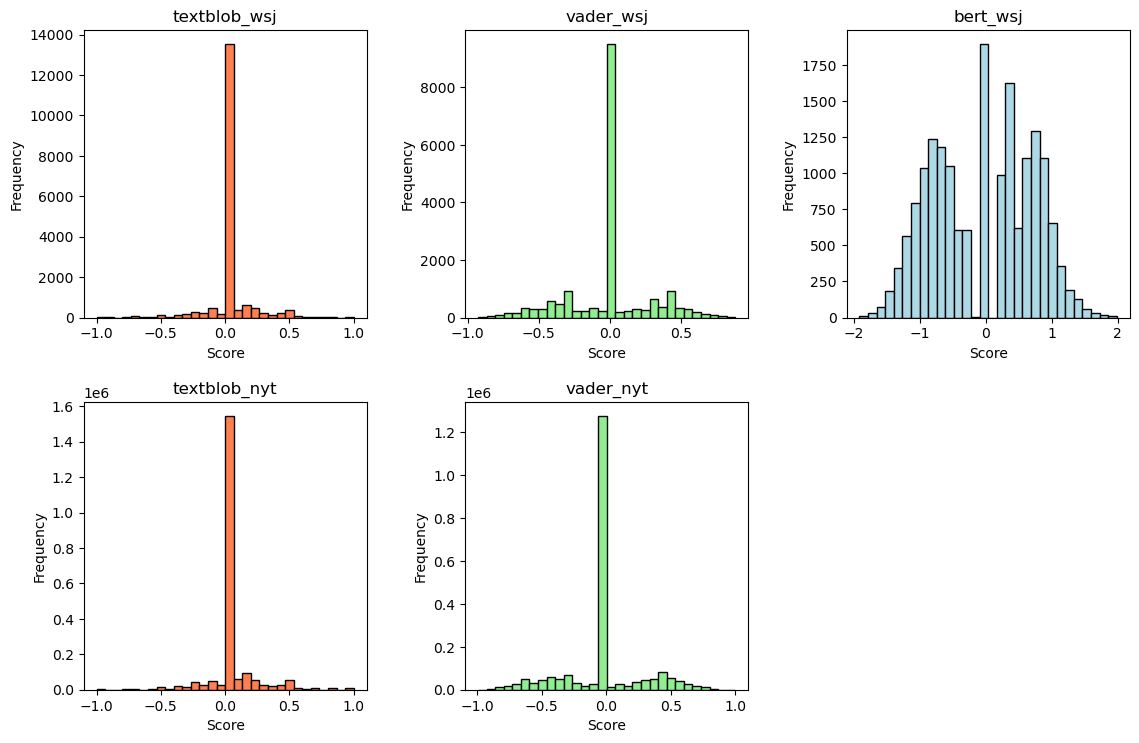

In [5]:
# Plot specs
n_plots = len(sentiment_cols)
n_cols = 3
n_rows = math.ceil(n_plots / n_cols)

# Plot
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 4))
fig.tight_layout(pad=4.0)
axes = axes.flatten()
colors = ["coral", "lightgreen", "lightblue"]

for i, col in enumerate(sentiment_cols):
    ax = axes[i]
    if col in df_nyt.columns:
        data = df_nyt[col]
    elif col in df_wsj.columns:
        data = df_wsj[col]
    ax.hist(data, bins=30, edgecolor='k', color=colors[i%n_cols])
    ax.set_title(sentiment_cols[i])
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')

fig.delaxes(axes[5])
plt.show()

We can see that for both NYT and WSJ, Textblob and VADER mark most headlines as having neutral sentiment (we can see a sharp spike in frequency at a score of 0, which is neutral). This is likely because headlines are quite short (on average 6 words), so it can be difficult to draw out sentiment from them. Between the two, however, we can see that VADER provides relatively fewer zero scores than Textblob does. Compared to Textblob and VADER, however, we see that BERT marks a significantly higher proportion of headlines with nonzero scores (meaning either positive or negative sentiment). This indicates that BERT is better at classifying the sentiment of headlines, so we will use BERT rather than the other two methods for WSJ data (unfortunately, because the NYT dataset is so large, it is infeasible to run BERT on it).

In [6]:
def get_word_cloud(df, source):
    text = " ".join(headline for headline in df['headline'])
    filtered_text = " ".join(word.lower() for word in text.split() if len(word) > 1 and word.isalpha())

    word_cloud = WordCloud(
        background_color="white",
        max_words=1000,
        width=800,
        height=400,
        collocations=False 
    ).generate(filtered_text)

    plt.figure(figsize=(10, 6))
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"Word Cloud of {source} Headlines (Filtered > 1 letter word)")
    plt.show()

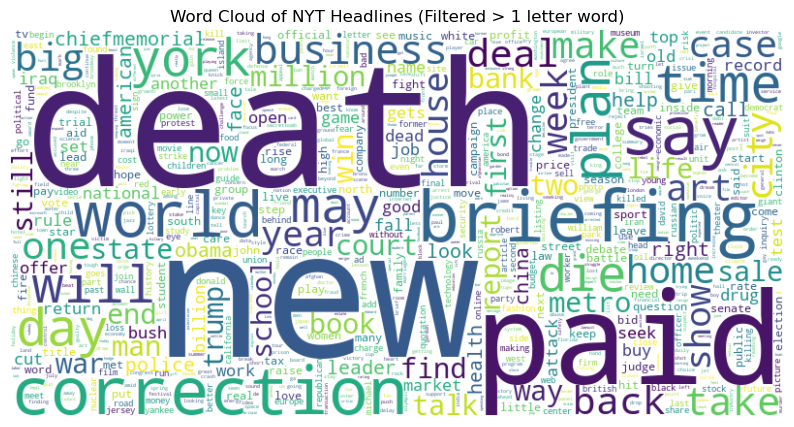

In [7]:
get_word_cloud(df_nyt, "NYT")

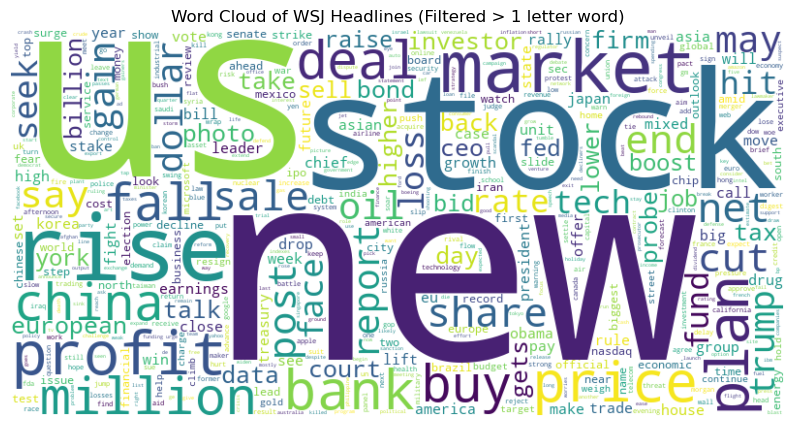

In [8]:
get_word_cloud(df_wsj, "WSJ")

The word clouds show the most common words in NYT and WSJ headlines, filtering out functional words like "like," "as," and "for." Comparing the two clouds is particularly interesting because it shows the different focus each paper has -- NYT's frequent words like "new," "death," "paid," and "briefing" show its focus on broader world news, while WSJ's frequent words like "market," "stock," and "rise" show its focus on the economy and stock market (which might be more relevant for predicting S&P data). We can also see that for both papers, several common words indicate broader sentiment ("rise" and "profit" are positive, for example), showing that these headlines may indeed capture broader sentiment in the country and economy at the time.

### **Aggregating Monthly Sentiment Scores**

We now aggregate the sentiment scores from the NYT and WSJ datasets on a monthly basis. A new column `year_month` is created in each dataset to represent the year and month of each headline. The sentiment scores for each month are calculated by excluding neutral sentiment scores (i.e. scores of 0) and averaging the sentiment for each month. This ensures the monthly averages reflect only meaningful (positive or negative) sentiments.

The aggregated monthly sentiment scores from the NYT and WSJ datasets are then combined into a single data frame, aligning the data on the `year_month` column.

In [9]:
# Create a month column
df_nyt['date'] = pd.to_datetime(df_nyt['date']).dt.tz_localize(None)
df_wsj['date'] = pd.to_datetime(df_wsj['date']).dt.tz_localize(None)
df_nyt['year_month'] = df_nyt['date'].dt.to_period('M')
df_wsj['year_month'] = df_wsj['date'].dt.to_period('M')

# Aggregate sentiment scores removing neutral (0) scores
def mean_ignore_zero(series):
    return series[series != 0].mean()

nyt_monthly_avg = df_nyt.groupby('year_month')[nyt_sentiment_cols].agg(mean_ignore_zero)
wsj_monthly_avg = df_wsj.groupby('year_month')[wsj_sentiment_cols].agg(mean_ignore_zero)

In [10]:
# Combine NYT and WSJ data
monthly_avg = pd.concat([nyt_monthly_avg, wsj_monthly_avg], axis=1)
monthly_avg = monthly_avg.reset_index()
display(monthly_avg.head())

,year_month,textblob_nyt,vader_nyt,textblob_wsj,vader_wsj,bert_wsj
0,1998-07,0.098459,-0.020807,0.119375,0.042477,-0.047076
1,1998-08,0.100825,-0.020114,0.078856,0.053012,-0.058711
2,1998-09,0.101843,-0.008985,0.100000,0.068224,-0.003143
3,1998-10,0.098454,-0.000390,0.143914,0.108588,0.132225
4,1998-11,0.086301,0.007860,-0.171111,-0.079321,-0.053441


#### **Scaling Sentiment Scores**

To ensure that our scores are of similar magnitude, we will scale our sentiment scores between -1 and 1.

In [11]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(monthly_avg[sentiment_cols])
monthly_avg[sentiment_cols] = scaled_values

display(monthly_avg.head())

,year_month,textblob_nyt,vader_nyt,textblob_wsj,vader_wsj,bert_wsj
0,1998-07,-0.194118,0.221210,0.189212,0.179135,-0.003294
1,1998-08,-0.144381,0.229742,0.023334,0.221660,-0.034428
2,1998-09,-0.122974,0.366776,0.109894,0.283067,0.114269
3,1998-10,-0.194217,0.472602,0.289672,0.445999,0.476502
4,1998-11,-0.449710,0.574187,-1.000000,-0.312517,-0.020326


_______________

## **S&P 500 Data**

Now that we have thoroughly explored the NYT and WSJ headline data supplemented with sentiment scores, let's take a look at the S&P 500 data. This data is part of Python’s built-in Yahoo Finance function (yfinance).

In [12]:
# Match start and end date of NYT and WSJ headlines
start_date = monthly_avg['year_month'].dt.start_time.min().strftime('%Y-%m-%d')
end_date = monthly_avg['year_month'].dt.end_time.max().strftime('%Y-%m-%d')

In [13]:
# Fetch S&P 500 data
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(start=start_date, end=end_date, interval="1mo")

monthly_closing_prices = sp500_data[['Close']].copy()
monthly_closing_prices.reset_index(inplace=True)
monthly_closing_prices['Date'] = monthly_closing_prices['Date'].dt.strftime('%Y-%m')
monthly_closing_prices['Date'] = pd.to_datetime(monthly_closing_prices['Date'])

In [14]:
# Display the data
print("Monthly Closing Prices of S&P 500:")
display(monthly_closing_prices.head(5))

Monthly Closing Prices of S&P 500:


,Date,Close
0,1998-07-01,1120.670044
1,1998-08-01,957.280029
2,1998-09-01,1017.010010
3,1998-10-01,1098.670044
4,1998-11-01,1163.630005


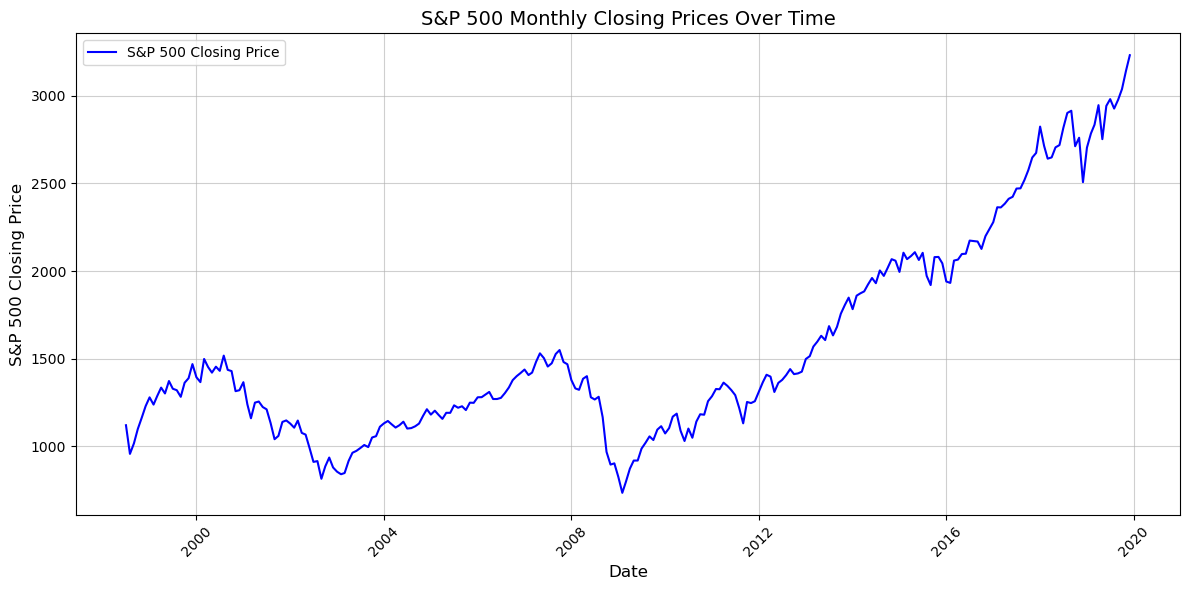

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_closing_prices['Date'], monthly_closing_prices['Close'], label='S&P 500 Closing Price', color='blue')
plt.xlabel('Date', fontsize=12)
plt.ylabel('S&P 500 Closing Price', fontsize=12)
plt.title('S&P 500 Monthly Closing Prices Over Time', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can see that the S&P 500 generally trended up in the period from 1988-2020; more accurately, we see the S&P staying within the 1000-1500 band between 1998-2010 and then increasing broadly since 2010 following the end of the Great Recession. Despite this trend up, however, we can see that there were several months that closed down from the previous month, indicating that there is still value in being able to predict when the market will decline.

_______

## **Combine Headlines and S&P 500 Data**

Now that the S&P 500 data has been cleaned and aggregated by month, we will combine the aggregated monthly sentiment scores from the NYT and WSJ datasets with the closing prices, aligning the data on the `year_month` column.

In [16]:
monthly_closing_prices.sort_values('Date', inplace=True)
monthly_closing_prices['Change'] = monthly_closing_prices['Close'].diff()

# Add a column to indicate increase (1) or decrease (-1)
monthly_closing_prices['SP500_Trend'] = monthly_closing_prices['Change'].apply(lambda x: 1 if x > 0 else -1)
scaler = MinMaxScaler(feature_range=(-1, 1))
monthly_closing_prices['scaled_close'] = scaler.fit_transform(monthly_closing_prices[['Close']])

if isinstance(monthly_avg['year_month'].iloc[0], pd.Period):
    monthly_avg['year_month'] = monthly_avg['year_month'].dt.to_timestamp()

if 'SP500_Trend' not in monthly_avg.columns or 'scaled_close' not in monthly_avg.columns:
    monthly_avg = pd.merge(monthly_avg, monthly_closing_prices[['Date', 'SP500_Trend', 'scaled_close']], 
                           left_on='year_month', right_on='Date', how='left')
    monthly_avg.drop(columns=['Date'], inplace=True)
else:
    print("SP500_Trend and scaled_close columns already exist. Skipping merge.")

#### **Final Dataset**

Let's take a peak at the newly combined dataframe! It should have the year-month, the TextBlob, VADER, and BERT (WSJ only) sentiment scores for NYT and WSJ headlines, as well as the SP500 trend (increase/decrease) and scaled closing price.

In [17]:
display(monthly_avg.head())

,year_month,textblob_nyt,vader_nyt,textblob_wsj,vader_wsj,bert_wsj,SP500_Trend,scaled_close
0,1998-07-01,-0.194118,0.221210,0.189212,0.179135,-0.003294,-1,-0.691003
1,1998-08-01,-0.144381,0.229742,0.023334,0.221660,-0.034428,-1,-0.821941
2,1998-09-01,-0.122974,0.366776,0.109894,0.283067,0.114269,1,-0.774075
3,1998-10-01,-0.194217,0.472602,0.289672,0.445999,0.476502,1,-0.708634
4,1998-11-01,-0.449710,0.574187,-1.000000,-0.312517,-0.020326,1,-0.656576


#### **Test and Train Sets**

Great! Now that we have our final dataset, we can split it into our train and test set. Since we are dealing with time series data, we will save the last 2 years of data for our test set.

In [18]:
# Define the test cutoff date for the last 2 years
monthly_avg['year_month'] = pd.to_datetime(monthly_avg['year_month'])
cutoff_date = monthly_avg['year_month'].max() - pd.DateOffset(years=2)

# Split
train = monthly_avg[monthly_avg['year_month'] <= cutoff_date]
test = monthly_avg[monthly_avg['year_month'] > cutoff_date]

X = ['textblob_nyt', 'vader_nyt', 'textblob_wsj', 'vader_wsj', 'bert_wsj']
y = ['SP500_Trend', 'scaled_close']
x_train, y_train = train[X], train[y]
x_test, y_test = test[X], test[y]

In [19]:
# Shapes of the splits
print("(num_obs, num_cols)")
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

(num_obs, num_cols)
x_train shape: (234, 5), y_train shape: (234, 2)
x_test shape: (24, 5), y_test shape: (24, 2)


#### **Plot Sentiment Scores and S&P Scaled Closing Prices**

We can now plot all 5 sentiment score metrics (all 3 methods for WSJ and VADER and Textblob for NYT) against the S&P scaled closing price.

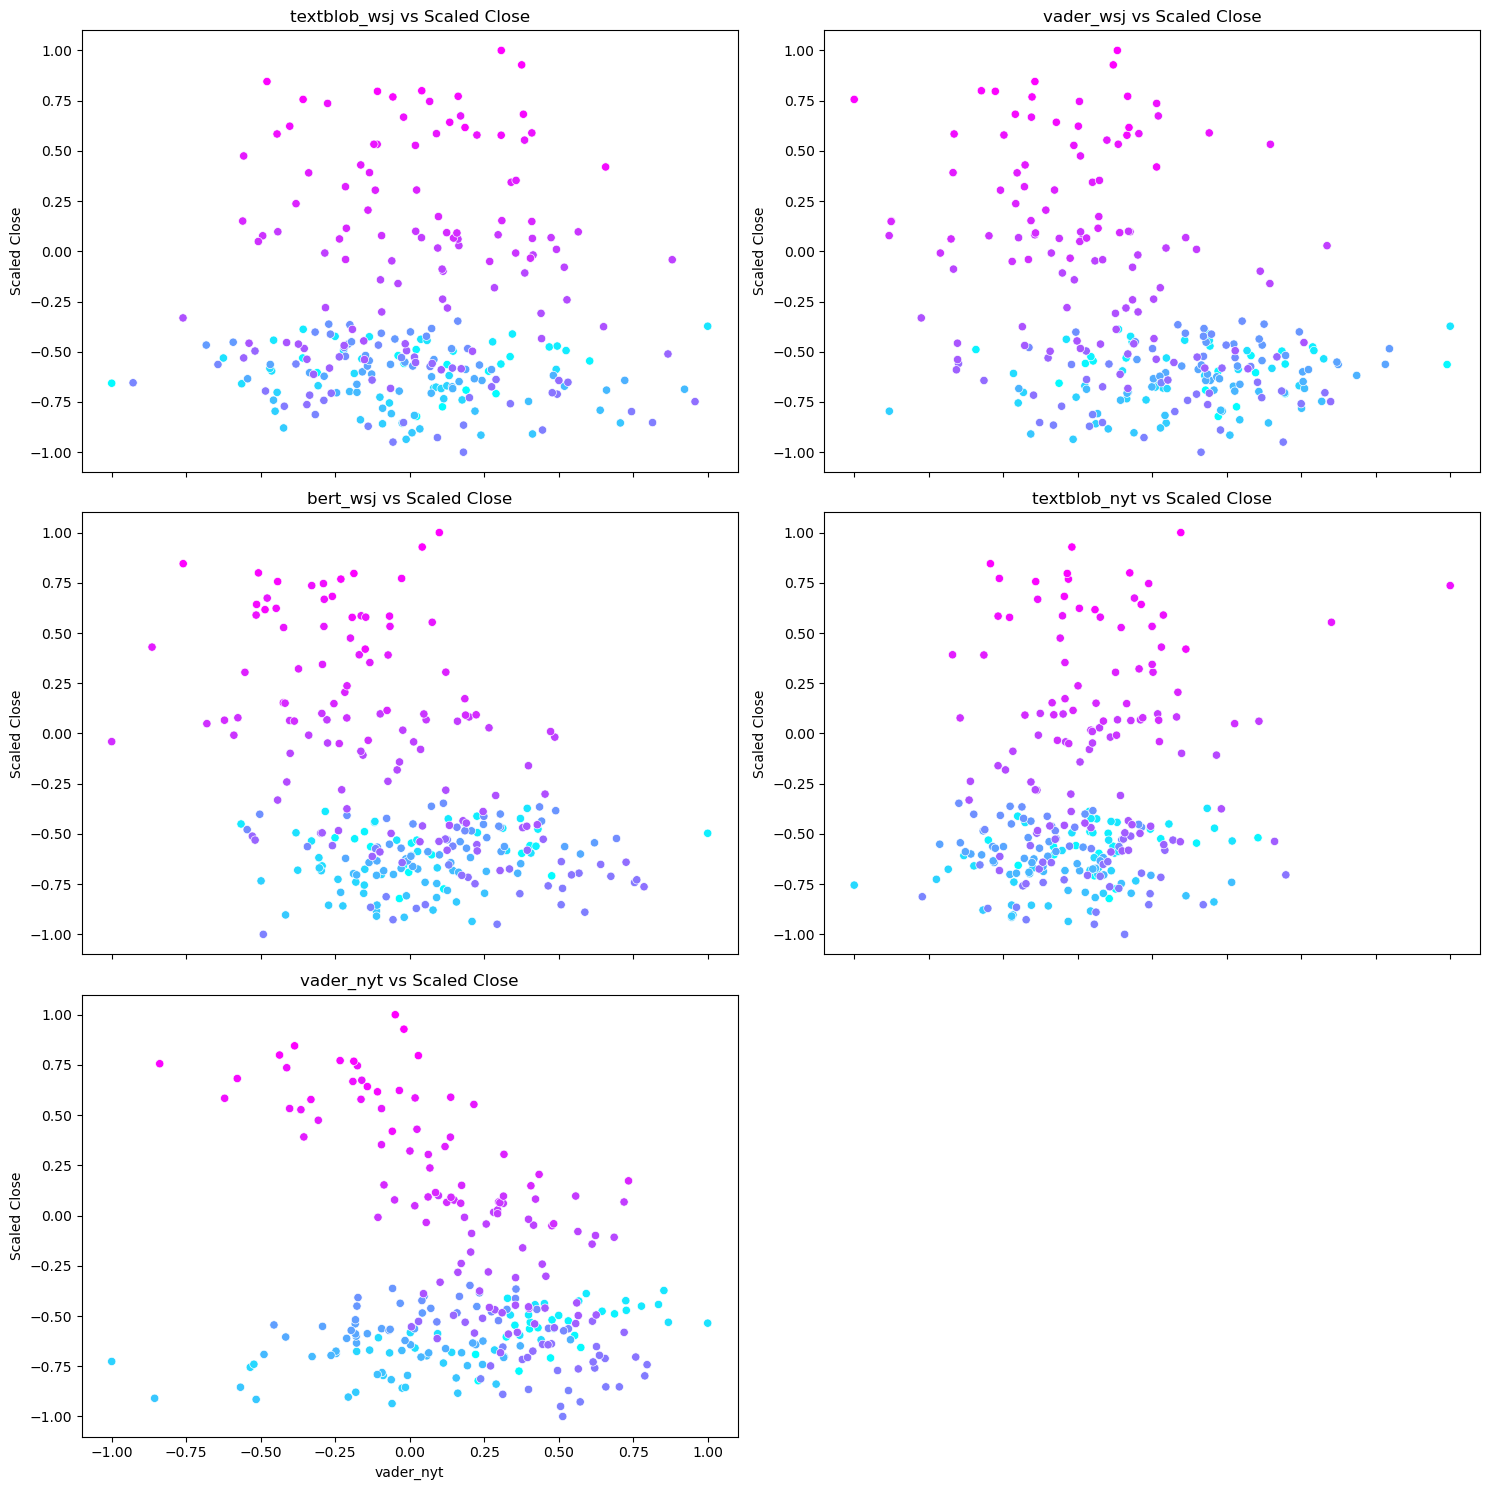

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharex=True)
axes = axes.flatten()

for i, col in enumerate(sentiment_cols):
    sns.scatterplot(
        ax=axes[i],
        data=monthly_avg,
        x=col,
        y='scaled_close',
        hue='year_month',
        palette='cool',
        legend=False
    )
    axes[i].set_title(f'{col} vs Scaled Close')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Scaled Close')

axes[5].axis('off')
plt.tight_layout()
plt.show()

Producing scatterplots of VADER, Textblob, and BERT for WSJ and VADER and Textblob for NYT against the S&P scaled closing price allows us to preliminarily see how the headline sentiment is associated with changes in the S&P price. We can see that the relationship seems to vary based on the sentiment method -- Textblob does not record many NYT headlines as having positive sentiment, for example, so most of the data is clustered at Textblob values of less than 0.5. Overall, it is difficult to deduce any clear relationship from these graphs. However, we can see that some do seem promising, like BERT on WSJ -- the data points generally seem to trend downward, meaning more positive headlines are associated with drops in the S&P. This is a bit counterintuitive, but is very interesting and merits further investigation.

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Baseline Models**

To predict changes in the S&P 500 closing prices using the sentiments of NY and WSJ headlines, we tested out several baseline models by casting this problem as both a regression and classification task.
1. **Regression Task**: 

    Can we quantitatively predict the S&P500 closing price of the next month using our sentiment scores?
2. **Classification Task**: 

    Can we predict whether the S&P500 closing price will increase or decrease the next month given our sentiment scores?

_____________________

## **1. Regression Task Baselines**

First, we tested out casting this problem as a regression task. To predict the S&P closing price of the next month, we used Linear Regression and KNN regression as our baseline models.

#### **Linear Regression**

For our baseline for the Linear Regression model, we predicting S&P price with Textblob and VADER sentiment scores. We incorporated regularization by using LASSO and Ridge regression.

In [21]:
# Hyperparameters
def create_pipeline(model):
    return Pipeline([
        ('poly', PolynomialFeatures()),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

ridge = Ridge(fit_intercept=False)
lasso = Lasso(fit_intercept=False)

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5], 
    'model__alpha': [0.1, 1, 10, 100] 
}

In [22]:
# Fit models
ridge_pipeline = create_pipeline(ridge)
ridge_grid = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(x_train, y_train)
best_ridge_model = ridge_grid.best_estimator_

lasso_pipeline = create_pipeline(lasso)
lasso_grid = GridSearchCV(lasso_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(x_train, y_train)
best_lasso_model = lasso_grid.best_estimator_

In [23]:
# Parameters
print("Best Ridge Model:")
print(f"Degree: {ridge_grid.best_params_['poly__degree']}")
print(f"Alpha: {ridge_grid.best_params_['model__alpha']}")

print("\nBest Lasso Model:")
print(f"Degree: {lasso_grid.best_params_['poly__degree']}")
print(f"Alpha: {lasso_grid.best_params_['model__alpha']}")

Best Ridge Model:
Degree: 1
Alpha: 100

Best Lasso Model:
Degree: 1
Alpha: 1


In [24]:
# Regularized coefficients
ridge_feature_names = best_ridge_model.named_steps['poly'].get_feature_names_out(input_features=x_train.columns)
lasso_feature_names = best_lasso_model.named_steps['poly'].get_feature_names_out(input_features=x_train.columns)
ridge_coefficients = best_ridge_model.named_steps['model'].coef_[1]
lasso_coefficients = best_lasso_model.named_steps['model'].coef_[1]

ridge_table = pd.DataFrame({
    'Feature': ridge_feature_names,
    'Coefficient': ridge_coefficients
})

lasso_table = pd.DataFrame({
    'Feature': lasso_feature_names,
    'Coefficient': lasso_coefficients
})

print("Ridge Model Features and Coefficients:")
display(ridge_table)

print("\nLasso Model Features and Coefficients:")
display(lasso_table)

Ridge Model Features and Coefficients:


,Feature,Coefficient
0,1,0.000000
1,textblob_nyt,0.037318
2,vader_nyt,0.004102
3,textblob_wsj,0.005642
4,vader_wsj,-0.068640
5,bert_wsj,-0.049540



Lasso Model Features and Coefficients:


,Feature,Coefficient
0,1,0.0
1,textblob_nyt,0.0
2,vader_nyt,0.0
3,textblob_wsj,-0.0
4,vader_wsj,-0.0
5,bert_wsj,-0.0


In the Ridge model, the feature coefficients vary more significantly. The most notable coefficients are for the features textblob_nyt (0.037318) and vader_nyt (0.004102), suggesting that these features have a positive contribution to the prediction of the target variable. The vader_wsj and bert_wsj features have negative coefficients (-0.068640 and -0.049540, respectively), indicating a negative relationship with the target.

The Lasso model, on the other hand, has many zero coefficients. Specifically, the coefficients for all features are zero or very close to zero (textblob_nyt, vader_nyt, textblob_wsj, vader_wsj, and bert_wsj), suggesting that Lasso has effectively eliminated these features from the model.

In [25]:
ridge_train_mse = -ridge_grid.best_score_
lasso_train_mse = -lasso_grid.best_score_

ridge_preds = best_ridge_model.predict(x_test)
lasso_preds = best_lasso_model.predict(x_test)
ridge_test_mse = mean_squared_error(y_test, ridge_preds)
lasso_test_mse = mean_squared_error(y_test, lasso_preds)

# Metrics table
linreg_metrics = pd.DataFrame({
    "Model": ["Ridge", "LASSO"],
    "Train MSE": [ridge_train_mse, lasso_train_mse],
    "Test MSE": [ridge_test_mse, lasso_test_mse],
})
display(linreg_metrics)

,Model,Train MSE,Test MSE
0,Ridge,0.658647,0.724811
1,LASSO,0.656634,0.743544


#### **KNN Regression**

As stock prices are sequential and build upon each other (for example, prices rising on Monday might indicate rising confidence in the market, prompting more investors to buy, further increasing prices on Tuesday), we decided to try fitting a kNN model on the data to see if such a model can better model the relationship between NYT headlines and S&P data.

In [26]:
# Fit KNN model
knn = KNeighborsRegressor()
param_grid = {'n_neighbors': range(1, 21)} 
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='r2')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 21)}, scoring='r2')

In [27]:
best_knn = grid_search.best_estimator_
best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f"Best n_neighbors: {best_n_neighbors}")

knn_train_preds = best_knn.predict(x_train)
knn_train_mse = mean_squared_error(y_train, knn_train_preds)
knn_test_preds = best_knn.predict(x_test)
knn_test_mse = mean_squared_error(y_test, knn_test_preds)
print(f"Train MSE: {knn_train_mse:.2f}")
print(f"Test MSE: {knn_test_mse:.2f}")

Best n_neighbors: 16
Train MSE: 0.49
Test MSE: 0.97


Due to the high MSE compared to the scaled response variable, this would mean that our predicted S&P 500 scores would be significatly incorrect compared to its actual value.

_____________

## **2. Classification Task Baseline**

Since our test MSEs for the linear regression and KNN models are quite high, we see that these models are not very good at predicting the S&P price. It makes sense, since the patterns in exact S&P price movements are likely very complex if they even exist at all, and are going to be very hard to predict with any degree of accuracy using simple models.

As a result, we decided to try classification instead of regression, and simply predicting whether or not the S&P price will go up or down, rather than an exact price.

### **Majority Class**

For our baseline model, we will use majority class for the classification task.

In [28]:
y_train_trend = y_train['SP500_Trend']
y_test_trend = y_test['SP500_Trend']

# Determine the majority class
majority_class = y_train_trend.mode()[0]

y_train_majority_pred = [majority_class] * len(y_train_trend)
y_test_majority_pred = [majority_class] * len(y_test_trend)

maj_train_accuracy = accuracy_score(y_train_trend, y_train_majority_pred)
maj_test_accuracy = accuracy_score(y_test_trend, y_test_majority_pred)

In [29]:
print(f"Majority Class: {majority_class}")
print(f"Train Accuracy: {maj_train_accuracy:.2f}")
print(f"Test Accuracy: {maj_test_accuracy:.2f}")

Majority Class: 1
Train Accuracy: 0.61
Test Accuracy: 0.75


#### **Rebalancing the Dataset**

Given the train accuracy of the majority class model, there is a data imbalance. This is because the S&P generally trends up over time, so there are significantly more months with positive changes than months with negative changes.

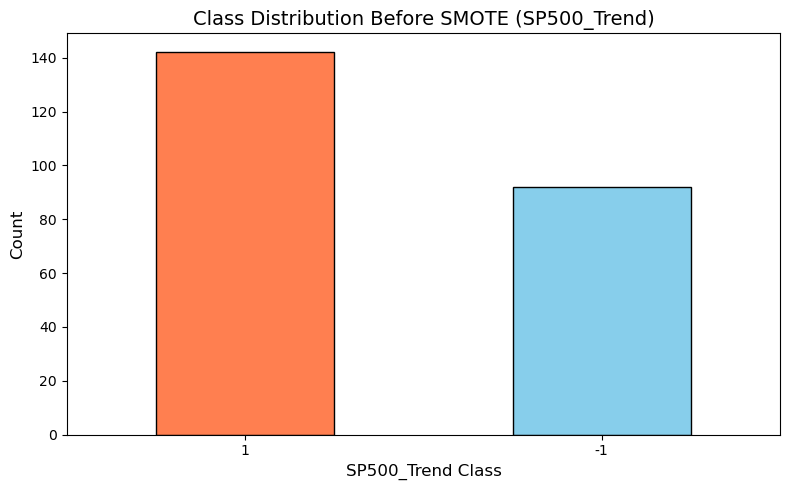

In [30]:
plt.figure(figsize=(8, 5))
y_train['SP500_Trend'].value_counts().plot(kind='bar', color=['coral', 'skyblue'], edgecolor='black')
plt.title('Class Distribution Before SMOTE (SP500_Trend)', fontsize=14)
plt.xlabel('SP500_Trend Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Since there is an imbalance in class distributions, we will use SMOTE to generate a more balanced dataset.

In [31]:
smote = SMOTE(random_state=42)
x_train_balanced, y_train_trend_balanced = smote.fit_resample(x_train, y_train_trend)

n_synthetic_samples = len(y_train_trend_balanced) - len(y_train_trend)
synthetic_scaled_close = np.random.choice(y_train['scaled_close'], size=n_synthetic_samples, replace=True)
y_train_scaled_close_balanced = np.concatenate([y_train['scaled_close'].values, synthetic_scaled_close])
y_train_balanced = pd.DataFrame({
    'SP500_Trend': y_train_trend_balanced,
    'scaled_close': y_train_scaled_close_balanced
})

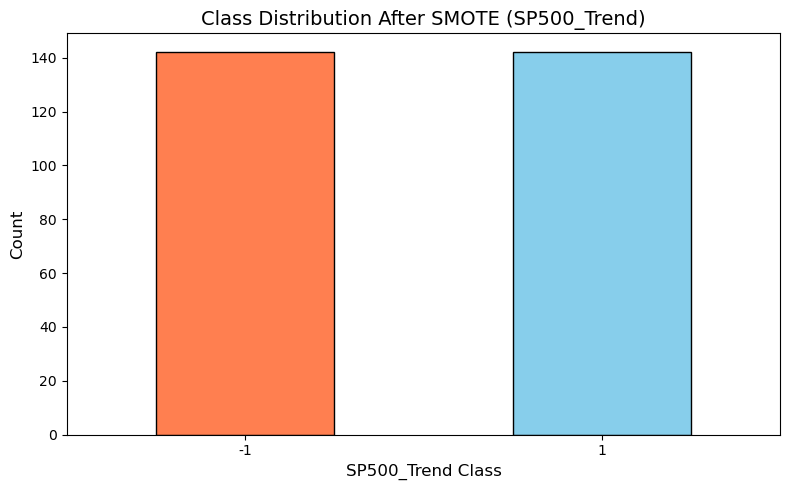

In [32]:
plt.figure(figsize=(8, 5))
y_train_balanced['SP500_Trend'].value_counts().plot(kind='bar', color=['coral', 'skyblue'], edgecolor='black')
plt.title('Class Distribution After SMOTE (SP500_Trend)', fontsize=14)
plt.xlabel('SP500_Trend Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Now the dataset is balanced between months with positive and negative closing changes!

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Final Models**

As the image of the pipeline below shows, we went through several steps to reach our final model: collecting and pre-processing the data, fitting regression models (linear regression and kNN) and finding they did not fit the data very well, and finally fitting several classification models. Our basic classification model was a majority classifier, which performed relatively well on the data, but did so only because the S&P generally trends up over time. We will therefore use two other classifiers for our final model: Random Forest and Boosting.

#### **Pipeline**

![pipeline.jpg](pipeline.jpg)

### **Random Forest Model**

In [33]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [34]:
# Tuning parameters for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit model
y_train_trend, y_test_trend = y_train['SP500_Trend'], y_test['SP500_Trend']
grid_search.fit(x_train_balanced, y_train_trend_balanced)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [35]:
# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


In [36]:
# Evaluate performance
best_rf_model = grid_search.best_estimator_
y_train_pred = best_rf_model.predict(x_train)
y_test_pred = best_rf_model.predict(x_test)

print("Test Performance:")
print(classification_report(y_test_trend, y_test_pred))

rf_train_accuracy = accuracy_score(y_train_trend, y_train_pred)
rf_test_accuracy = accuracy_score(y_test_trend, y_test_pred)
print("Train Accuracy:", rf_train_accuracy)
print("Test Accuracy:", rf_test_accuracy)

print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test_trend, y_test_pred))

Test Performance:
              precision    recall  f1-score   support

          -1       0.38      0.50      0.43         6
           1       0.81      0.72      0.76        18

    accuracy                           0.67        24
   macro avg       0.59      0.61      0.60        24
weighted avg       0.70      0.67      0.68        24

Train Accuracy: 0.9957264957264957
Test Accuracy: 0.6666666666666666

Confusion Matrix (Test Set):
[[ 3  3]
 [ 5 13]]


### **AdaBoost Model**

In [ ]:
# Tuning parameters for AdaBoost
param_grid = {
    'n_estimators': [50, 75, 100, 125],  
    'learning_rate': [0.1, 0.2, 1.0],
    'estimator': [
        DecisionTreeClassifier(max_depth=1, random_state=42, class_weight='balanced'),
        DecisionTreeClassifier(max_depth=2, random_state=42, class_weight='balanced')
    ]
}

adaboost_model = AdaBoostClassifier(random_state=42)
grid_search = GridSearchCV(estimator=adaboost_model, param_grid=param_grid, 
                           cv=3, scoring='accuracy', n_jobs=2, verbose=1)
grid_search.fit(x_train_balanced, y_train_trend_balanced)

In [38]:
# Print best parameters
best_adaboost_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=42), 'learning_rate': 1.0, 'n_estimators': 50}


In [39]:
# Evaluate
y_train_pred = best_adaboost_model.predict(x_train)
y_test_pred = best_adaboost_model.predict(x_test)

print("\nTest Performance:")
print(classification_report(y_test_trend, y_test_pred))

ada_train_accuracy = accuracy_score(y_train_trend, y_train_pred)
ada_test_accuracy = accuracy_score(y_test_trend, y_test_pred)
print("Train Accuracy:", ada_train_accuracy)
print("Test Accuracy:", ada_test_accuracy)

print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test_trend, y_test_pred))


Test Performance:
              precision    recall  f1-score   support

          -1       0.33      0.83      0.48         6
           1       0.89      0.44      0.59        18

    accuracy                           0.54        24
   macro avg       0.61      0.64      0.53        24
weighted avg       0.75      0.54      0.56        24

Train Accuracy: 1.0
Test Accuracy: 0.5416666666666666

Confusion Matrix (Test Set):
[[ 5  1]
 [10  8]]


<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Investment Simulation**

Although the test accuracy is a helpful metric, it is also helpful to understand how these models would perform if they were implemented as an investment strategy, so we will create a simulation to model how much money each would end with in the last two years (the test period) if they all started at $1000. Note that we run several models and interpret them all at the end.

#### **No Shorting**

In [40]:
# Simulate portfolio
def simulate_investment(model_predictions, actual_changes, initial_investment):
    portfolio = initial_investment
    portfolio_history = [portfolio]
    
    for prediction, actual_change in zip(model_predictions, actual_changes):
        if prediction == 1: 
            portfolio *= (1 + actual_change)
        portfolio_history.append(portfolio)
    
    return portfolio_history

In [41]:
# Run simulations and store in variables
actual_changes = (y_test['scaled_close'].values[1:] - y_test['scaled_close'].values[:-1]) / y_test['scaled_close'].values[:-1]
initial_investment = 1000

rf_predictions = best_rf_model.predict(x_test)
boosting_predictions = best_adaboost_model.predict(x_test)
majority_class_predictions = [y_train_trend.mode()[0]] * len(y_test)

rf_portfolio = simulate_investment(rf_predictions, actual_changes, initial_investment)
boosting_portfolio = simulate_investment(boosting_predictions, actual_changes, initial_investment)
majority_portfolio = simulate_investment(majority_class_predictions, actual_changes, initial_investment)

simulation_results = pd.DataFrame({
    'Month': np.arange(len(rf_portfolio)),
    'Random Forest': rf_portfolio,
    'Boosting': boosting_portfolio,
    'Majority Class': majority_portfolio
})

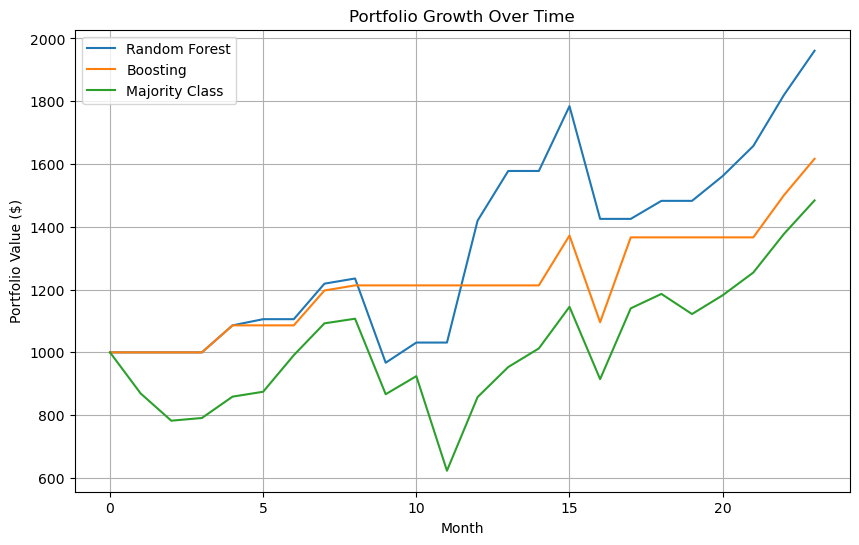

In [42]:
# Plot simulation results
plt.figure(figsize=(10, 6))
plt.plot(simulation_results['Month'], simulation_results['Random Forest'], label='Random Forest')
plt.plot(simulation_results['Month'], simulation_results['Boosting'], label='Boosting')
plt.plot(simulation_results['Month'], simulation_results['Majority Class'], label='Majority Class')
plt.title('Portfolio Growth Over Time')
plt.xlabel('Month')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
print("Final Portfolio Values:")
display(simulation_results.iloc[-1])

Final Portfolio Values:


Month               23.000000
Random Forest     1960.781820
Boosting          1616.656190
Majority Class    1483.983893
Name: 23, dtype: float64

#### **Shorting**

In [44]:
# Simulate portfolio that shorts
def simulate_investment_with_shorting(model_predictions, actual_changes, initial_investment):
    portfolio = initial_investment
    portfolio_history = [portfolio]
    
    for prediction, actual_change in zip(model_predictions, actual_changes):
        if prediction == 1:  
            portfolio *= (1 + actual_change) 
        elif prediction == -1: 
            portfolio *= (1 - actual_change) 
        portfolio_history.append(portfolio)
    
    return portfolio_history

In [45]:
# Simulate portfolio that always invests (mimics the market)
def simulate_always_invest(actual_changes, initial_investment):
    portfolio = initial_investment
    portfolio_history = [portfolio]
    
    for actual_change in actual_changes:
        portfolio *= (1 + actual_change)  # Always invest
        portfolio_history.append(portfolio)
    
    return portfolio_history

In [46]:
# Run shorting simulation
initial_investment = 1000 
actual_changes = (y_test['scaled_close'].values[1:] - y_test['scaled_close'].values[:-1]) / y_test['scaled_close'].values[:-1]

rf_predictions = best_rf_model.predict(x_test)  
boosting_predictions = best_adaboost_model.predict(x_test) 
majority_class_predictions = [y_train_trend.mode()[0]] * len(y_test)

rf_portfolio_shorting = simulate_investment_with_shorting(rf_predictions, actual_changes, initial_investment)
boosting_portfolio_shorting = simulate_investment_with_shorting(boosting_predictions, actual_changes, initial_investment)
majority_portfolio_shorting = simulate_investment_with_shorting(majority_class_predictions, actual_changes, initial_investment)

simulation_results = pd.DataFrame({
    'Month': np.arange(len(rf_portfolio_shorting)),
    'Random Forest (Shorting)': rf_portfolio_shorting,
    'Boosting (Shorting)': boosting_portfolio_shorting,
    'Majority Class (Shorting)': majority_portfolio_shorting,
})

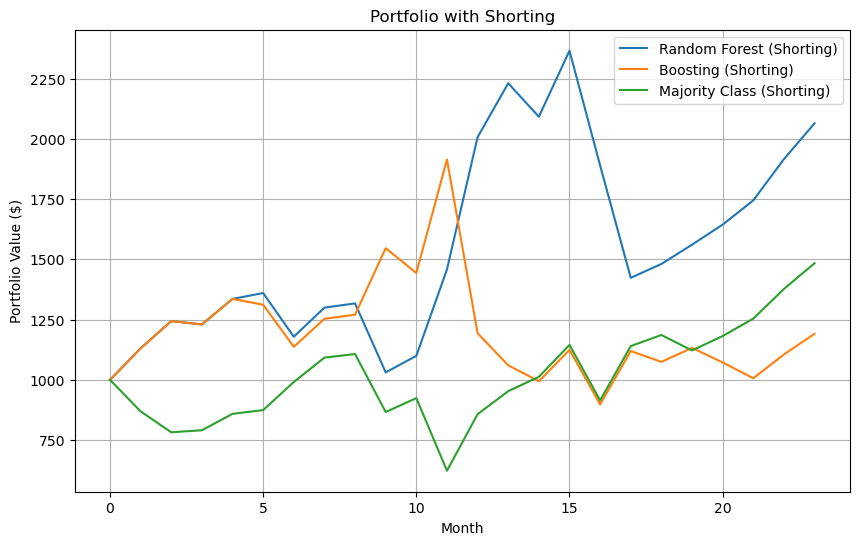

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(simulation_results['Month'], simulation_results['Random Forest (Shorting)'], label='Random Forest (Shorting)')
plt.plot(simulation_results['Month'], simulation_results['Boosting (Shorting)'], label='Boosting (Shorting)')
plt.plot(simulation_results['Month'], simulation_results['Majority Class (Shorting)'], label='Majority Class (Shorting)')
plt.title('Portfolio with Shorting')
plt.xlabel('Month')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
print("Final Portfolio Values with Shorting:")
print(simulation_results.iloc[-1])

Final Portfolio Values with Shorting:
Month                          23.000000
Random Forest (Shorting)     2064.327958
Boosting (Shorting)          1191.166372
Majority Class (Shorting)    1483.983893
Name: 23, dtype: float64


#### **Comparing Investment Strategies**

In [49]:
simulation_results = pd.DataFrame({
    'Month': np.arange(len(rf_portfolio)),
    'RF No Shorting': rf_portfolio,
    'Boosting No Shorting': boosting_portfolio,
    'Majority No Shorting': majority_portfolio,
    'RF Shorting': rf_portfolio_shorting,
    'Boosting Shorting': boosting_portfolio_shorting,
    'Majority Shorting': majority_portfolio_shorting,
})

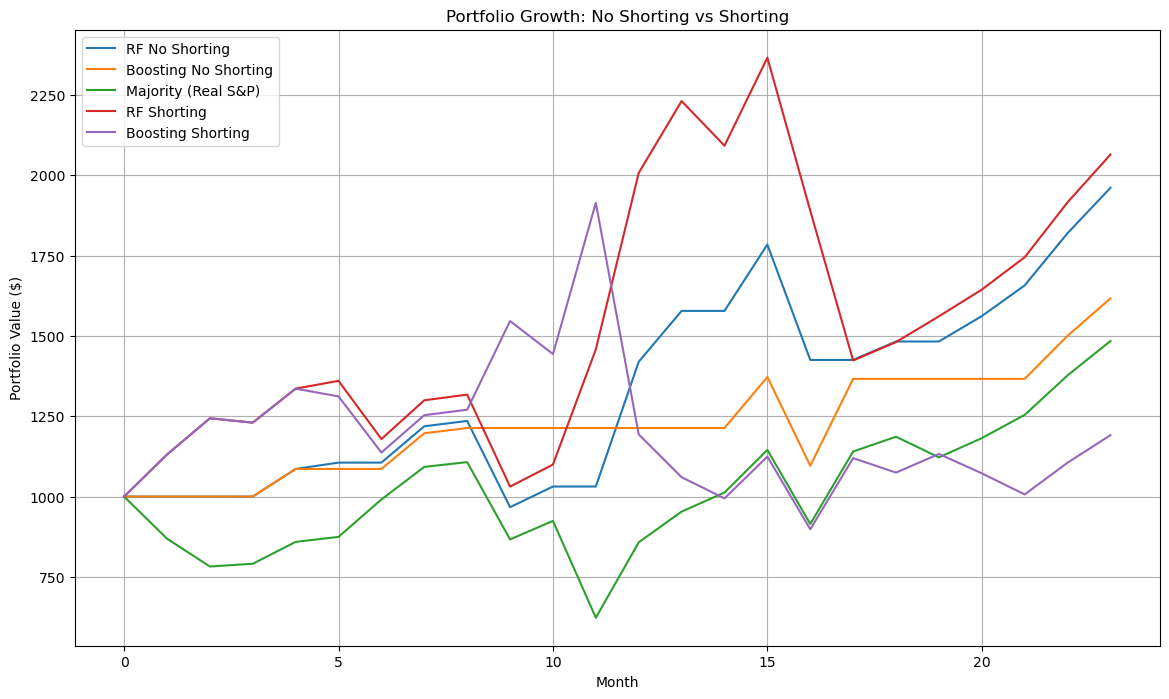

In [50]:
plt.figure(figsize=(14, 8))
plt.plot(simulation_results['Month'], simulation_results['RF No Shorting'], label='RF No Shorting')
plt.plot(simulation_results['Month'], simulation_results['Boosting No Shorting'], label='Boosting No Shorting')
plt.plot(simulation_results['Month'], simulation_results['Majority No Shorting'], label='Majority (Real S&P)')
plt.plot(simulation_results['Month'], simulation_results['RF Shorting'], label='RF Shorting')
plt.plot(simulation_results['Month'], simulation_results['Boosting Shorting'], label='Boosting Shorting')
plt.title('Portfolio Growth: No Shorting vs Shorting')
plt.xlabel('Month')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [51]:
print("Final Portfolio Values:")
print(simulation_results.iloc[-1])

Final Portfolio Values:
Month                     23.000000
RF No Shorting          1960.781820
Boosting No Shorting    1616.656190
Majority No Shorting    1483.983893
RF Shorting             2064.327958
Boosting Shorting       1191.166372
Majority Shorting       1483.983893
Name: 23, dtype: float64


In [52]:
peak_difference = np.max(np.abs(np.array(rf_portfolio) - np.array(majority_portfolio)))
peak_difference_shorting = np.max(np.abs(np.array(rf_portfolio_shorting) - np.array(majority_portfolio_shorting)))

print(f"Max Difference between RF and Majority Class: ${peak_difference:.2f}")
print(f"Max Difference between RF and Majority Class (shorting): ${peak_difference_shorting:.2f}")

Max Difference between RF and Majority Class: $639.13
Max Difference between RF and Majority Class (shorting): $1277.49


### **Simulation Report**

Here we analyze a portfolio with $1000 using multiple model types and investment strategies. There are 3 model types - our random forest, the AdaBoost method, and a majority class predictor. The two investment strategies are as follows:

**No Shorting**

Here, if the model predicts that the market will go up, it stays in the market. The total investment is updated based on the actual change in the market that takes place, in the line `portfolio *= (1 + actual_change)`. Note that actual change can be negative, so if it incorrectly predicts that the market will go up, the portfolio will decrease (and it will increase if it predicts correctly). If it predicts the market will go up, then it simply "sells" and thus the portfolio value stays the exact same and no change is made. Note: if a model only predicts that the market will go down, then it will appear to just be a straight line (since it will remain sold and never invest in the market, so the portfolio value will never change). This is sometimes true of our boosting model.

**Shorting**

Here, the logic is the same if it predicts the market will go up. However, if it predicts it will go down, it "shorts" the market and the portfolio changes by `portfolio *= (1 - actual_change)`. Thus if actual change is negative, the portfolio will go up, and if the actual change is positive, it will go down. The reason for introducing this method of investment was to fully capture the model - including rewarding true negatives and penalizing false negatives unlike the no shorting strategy which just rewards true positives and penalizes false negatives (since you don't lose money on false negatives or gain money on true negatives). Thus in the first investment strategy, if you had a very conservative model that had a true positive rate of 100% but a very high false negative rate, the portfolio would appear to only go up (since it would only invest when the market is about to go up but it would rarely invest). This captures more aspects of the model.

Note that the majority class predictor always predicts the market to go up, since that is the majority prediction, so it essentially just mimics the market (is equivalent to just leaving your money in the market and thus is a graph of the S&P). The best portfolio performance was by the random forest with shorting, which led to a final portfolio value of $2064 (compared to the majority class which had a portfolio value of $1484). Two things to note: first, this timescale is two years (which is relatively short as far as markets are concerned), so we would need more data to get a better idea of true performance of each model. Secondly, we see that the random forest with shorting has much more variance and can thus potentially lead to much better results at particular times as compared to the non shorting models (and thus feasibly also much worse results). For example, the peak difference at any point in time between the random forest with no shorting and the majority model was ~$650, while the peak difference between the shorting random forest and the majority model was ~$1200 (~$1100 vs ~$2300) which is a 110% better performance than the majority model. This is because the random forest with shorting can take advantage of correctly predicted decreases in the market and build upon that - this can be seen in the large decrease between month 10 and 11 that the random forest correctly predicts and is able to grow off of significantly, while the majority model suffers greatly that month. Note, however, this can lead to more dramatic portfolio crashes as well since it is inherently a more volatile investment strategy.

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Model Interpretation and Results**

Our results revealed some interesting patterns across different modeling approaches for predicting S&P 500 performance based on sentiment scores of NYT and WSJ headlines. At first, we attempted to predict the S&P stock prices, first using linear regression and then KNN. However, we ended up with test MSEs of 0.72 and 0.74 for Ridge and Lasso regression, respectively, and an MSE 0.97 for our KNN model. We concluded that it would be very difficult to get accurate predictions for exact stock prices, and decided to switch to a classification model to predict if the stock price would go up or down. We started off with a baseline model using majority class, which we found had an accuracy of 0.75. 

#### **Comparing Regression Model MSEs**

In [54]:
# Regression Model Metrics table
regression_metrics = pd.DataFrame({
    "Model": ["Ridge", "LASSO", "KNN (k=16)"],
    "Train MSE": [ridge_train_mse, lasso_train_mse, knn_train_mse],
    "Test MSE": [ridge_test_mse, lasso_test_mse, knn_test_mse],
})
display(regression_metrics)

,Model,Train MSE,Test MSE
0,Ridge,0.658647,0.724811
1,LASSO,0.656634,0.743544
2,KNN (k=16),0.489129,0.974363


Based on the metrics provided, the Ridge and Lasso models show similar performance, with both having relatively close train MSE (0.658647 and 0.656634) and test MSE (0.724811 and 0.743544). These models have slightly higher training and testing errors compared to the KNN model, particularly in terms of test MSE. The KNN model, with \( k = 16 \), achieves the lowest train MSE (0.489129), indicating it fits the training data well. However, the test MSE for KNN is significantly higher (0.974363), suggesting that the model might be overfitting to the training data and struggling to generalize to new, unseen data. 

In contrast, the Ridge and Lasso models seem to offer a better balance between train and test performance, with smaller test MSE values, which suggests that they generalize better despite potentially sacrificing some training accuracy due to regularization. Overall, while KNN has better performance on the training set, its poor test performance indicates that Ridge and Lasso may be more reliable choices for this particular dataset, offering better generalization.

#### **Comparing Classification Model Accuracies**

In [55]:
accuracies = {
    "Model": ["Majority Class", "Random Forest", "AdaBoost"],
    "Train Accuracy": [maj_train_accuracy, rf_train_accuracy, ada_train_accuracy],
    "Test Accuracy": [maj_test_accuracy, rf_test_accuracy, ada_test_accuracy],
}

display(pd.DataFrame(accuracies))

,Model,Train Accuracy,Test Accuracy
0,Majority Class,0.606838,0.750000
1,Random Forest,0.995726,0.666667
2,AdaBoost,1.000000,0.541667


The Majority Class model serves as a baseline model and this predicts the most frequent class for all observations given the original dataset. Its train accuracy of 60.68% suggests that it is able to capture the majority class reasonably well during training. The test accuracy of 75% is also high compared to the other models which we test. This could mean that the test set has a disproportionate amount of the majority class, but the model is not capturing any meaningful patterns beyond the simple majority prediction that the S&P500 increases most months. It is surprising that the test data is higher, but this is purely the result of the imbalance test dataset from 2017 - 2020.

The Random Forest model performs well on the training set with an accuracy of 99.57%, suggesting that it has learned higher level relationships in the S&P 500 data. Its performance  drops on the test set as expected where the accuracy becomes 66%. This is a surprisingly high accuracy score given the amount of possible noise in the dataset, even though it has a lower accuracy than the majority class. Random Forests tend to have high variance, and if not properly tuned it may overfit, leading to poor generalization on unseen data. It should be noted for classification results, accuracy alone is not necessarily the best indicator of success. For example, if a month has a lot of negative headlines indicating a potentially large decrease in stock price, predicting one negative result could compensate for missing a few positive results depending on their magnitude. We will revisit this idea later.

AdaBoost achieves perfect accuracy on the training data but has a drop in test accuracy of 54.16%. The high training accuracy indicates that the model has learned to fit the training data well which is expected by adaboost. AdaBoost can be prone to overfitting, especially when the base learners are too complex or the number of iterations is too high. This could mean we should train more simple stumps, or tune the model differently to better predict on the test data. It should be noted that the accuracy was better than that of the Random Forest, but for our specific simulation random forests better captured the larger changes in the S&P even though AdaBoost was accurate more often.

The Majority Class model is the least complex and acts as a baseline, showing the importance of using more sophisticated models, especially when class imbalance is present. Both Random Forest and AdaBoost perform well on the training set but struggle to generalize to the test set, which points to potential overfitting. The Random forest model has a decent test accuracy while being a more complex model, indicating that it might be learning something about the S&P500 trends that is significant. AdaBoost, while achieving perfect train accuracy, suffers more drastically in terms of test accuracy, though it still shows some overfitting.

AdaBoost achieves an F1-score of 0.48 for class -1 and 0.59 for class 1, while Random Forest scores 0.43 for class -1 and 0.76 for class 1. The weighted F1-score is higher for Random Forest (0.68) compared to AdaBoost (0.56), making Random Forest the better-performing model overall. AdaBoost might better predict down turns in the data, so there is an argument to incorporate adaboost as a negative predictor with a Random Forest predicting up turns in the market.

While AdaBoost and Random forest are more sophisticated models compared to the Majority Class model, both need further tuning and regularization to improve their generalization on the test set. We could use future techniques like cross-validation and hyperparameter tuning and model regularization which all could help improve the generalization of these models.

#### **Choosing the Best Model**

The best models that we chose were the random forest and adaboost models, with accuracies of 0.66 and 0.54 respectively. Surprisingly, these both underperformed compared to our majority class baseline model, which achieved 75% test accuracy suggesting that the relationship between the features and target variable may be more complex than initially assumed or that there might be significant noise in the data. Our results from the regression models also support this, since the fact that our ridge and lasso regressions both performed best with degree 1 polynomials signal that higher-order terms might lead to overfitting, and the KNN regression had a highly negative R^2 score, indicating that therelationship between features and the target variable isn't well-captured by local patterns.

Despite the baseline model having the highest accuracy, it's not necessarily the best model because it's not "learning" anything - it's just exploiting class imbalance since the stock market has a much higher tendency to go up over the long run than down. The random forest and adaboost, while having lower accuracy, is actually finding patterns in the data, meaning it has true predictive power that could generalize better to new data where class distributions might change, such as during more recessionary periods where the market falls more frequently. These models can also provide better insights about feature importance and provide probability estimates rather than just hard classifications. 

Additionally, in many real-world problems, the cost of false negatives and false positives isn't equal. The majority classifier simply predicts class 1 for everything. While this gives higher accuracy, it completely fails to identify any class -1 cases, and often times people care more about downside risk when it comes to managing their money than upside potential.


#### **Feature Importance**

As an exploratory step for this, we analyzed feature importance below by calculating MDI and permutation importance.

In [56]:
mdi_importances = best_rf_model.feature_importances_
feature_names = x_train.columns 

perm_importances = permutation_importance(
    best_rf_model, x_test, y_test_trend, n_repeats=10, random_state=42, n_jobs=-1
)
perm_mean_importances = perm_importances.importances_mean

importances_df = pd.DataFrame({
    'Feature': feature_names,
    'MDI Importance': mdi_importances,
    'Permutation Importance': perm_mean_importances
}).sort_values(by='MDI Importance', ascending=False)
display(importances_df)

,Feature,MDI Importance,Permutation Importance
4,bert_wsj,0.235625,0.145833
3,vader_wsj,0.222625,0.070833
0,textblob_nyt,0.198608,0.104167
1,vader_nyt,0.185454,0.050000
2,textblob_wsj,0.157687,0.125000


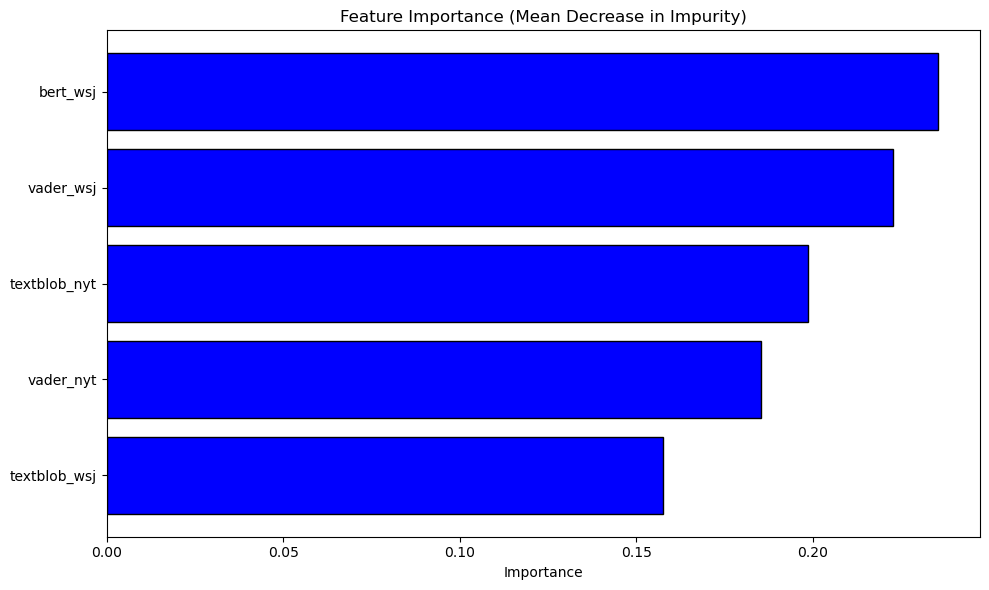

In [57]:
# MDI
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['MDI Importance'], color='blue', edgecolor='black')
plt.xlabel('Importance')
plt.title('Feature Importance (Mean Decrease in Impurity)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

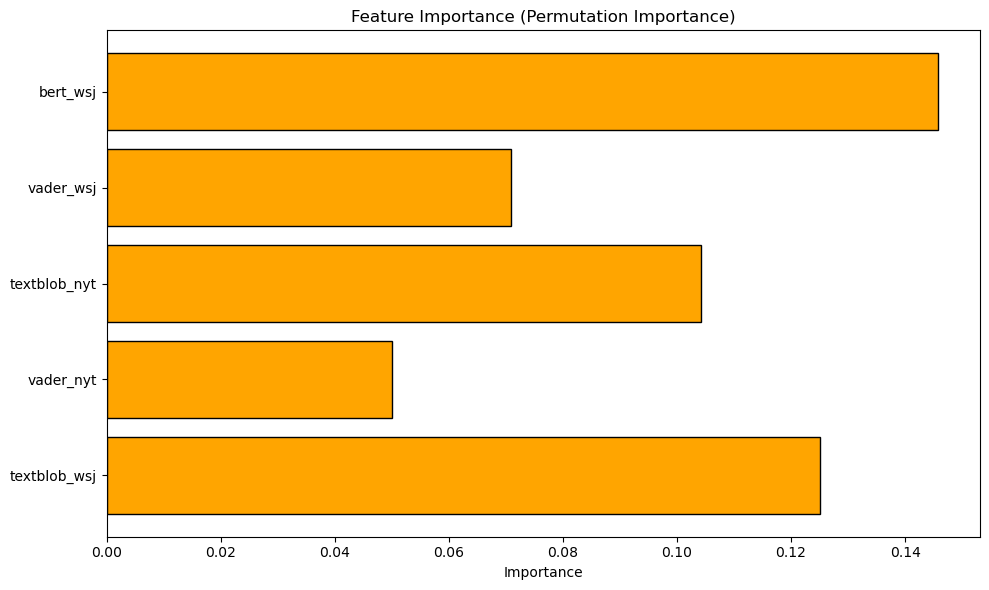

In [58]:
# Permutation Importance
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Permutation Importance'], color='orange', edgecolor='black')
plt.xlabel('Importance')
plt.title('Feature Importance (Permutation Importance)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

As we can see in the graphs above, the MDI and permutation importance seem to agree and only conflict on the feature importances of two of the features. Both MDI and permutation importance agree that BERT WSJ is the most important feature, with a significant contribution to the model's decision-making. Both MDI and permutation importance also rank Textblob NYT very highly, coming in at third place. The two metrics seem to conflict on the second most important feature. The MDI scores rank VADER WSJ second, while permutation importance ranks Textblob WSJ second. All three of these features are then followed by VADER WSJ and VADER NYT. 

These feature rankings suggests that BERT is a better predictor of the , which follows intuitively given the complexity of the model. Overall, it seems like the VADER scores arethe least important and do not have as much predictive power of the closing prices, and Textblob scores are pretty good at predicting.

Maybe, there are more siginfican WSJ overall in predictors, and this news source provides more signal to the S&P500 given that most of the top important features are the WSJ journal headline scores. However, more investigation and more sources / methods for sentiment analysis could be used in the future. For example, in the regressions, the WSJ coefficients were generally larger reguardless of the sentiment analysis method. This could point us to use a more complete WSJ dataset or similar news outlets.

#### **Future Work**

Our future work could focus on feature engineering, potentially incorporating domain knowledge to create more informative features. To do this, we could explore other types of sentiment analysis techniques. Our use of BERT, TextBlob, and VADER were simply directed by the fact that they calculate scores differently. Instead, we could use more specific metrics to asign these scores and better categorize the sentiment even with the short headlines. We could also add sentiment analysis to the article as a whole. This could provide us with a more complete picture of the sentiment of each article, though this would be a lot more computationally intensive. We could add other news sources, like the Washington Post or Financial Times, along with online trends to capture more up-to-date information. Also, changing the time period could make our results more reliable (ie. predicting over two months instead of one). Finally, we could explore ensemble methods that combine the strengths of multiple approaches, or implement more sophisticated preprocessing techniques could yield better results.

Thanks for reading! :)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>